# TensorFlow识别手写数字

## 加载MNIST数据集

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


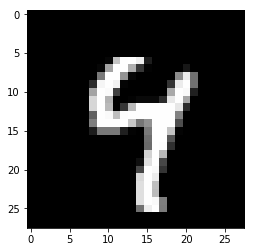

In [2]:
# 查看数据集图片
import matplotlib.pyplot as plt
%matplotlib inline

n = mnist.train.images[2].reshape(28, 28)
plt.imshow(n, cmap='gray')

In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

## 1. Softmax 回归模型

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [5]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [6]:
sess.run(tf.global_variables_initializer())

In [7]:
y = tf.matmul(x, W) + b
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))

In [8]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [9]:
for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [10]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9182


## 2. TensorFlow实现简单的CNN

加载数据集，并创建默认的InteractiveSession

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


创建权重和偏置的初始化函数以便重复使用

In [12]:
def weight_variable(shape):
    # 制造随机噪声用以打破完全对称，如 截断的正态分布噪声，标准差为0.1 
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # 为偏置增加一些小的正值0.1，避免dead neurons
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

定义卷积层和池化层

In [13]:
def conv2d(x, W):
    # tf.nn.conv2d
    # x: 输入
    # W: 卷积参数，如 [5, 5, 1, 32]表示卷积核的大小为5x5，通道个数为1，卷积核个数为32
    # strides: 移动的步长
    # padding: 边界处理方式
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # tf.nn.max_pool
    # x: 输入的tensor [batch, height, width, channels]
    # ksize: 核的大小，[1, 2, 2, 1]表示在1个样本上，2x2大小的核，1个通道
    # strides：与ksize类似
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

定义placeholder，x为特征，y_为真实的标签

In [14]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1]) # reshape为28x28的图像，1个通道，-1表示样本数量不固定

定义第一个卷积层

In [15]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

定义第二个卷积层

In [16]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

经过两次步长为2x2的池化，大小为原始图像的1/4，即7x7<br/>
定义最后的全连接层

In [17]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

为避免过拟合，使用一个Dropout层，训练时随机丢弃一部分节点的数据来减轻过拟合

In [18]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

将Dropout层连接最终的Softmax层，得到最终的概率输出

In [19]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

定义损失函数和优化算法

In [20]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



定义准确率的计算

In [21]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

开始训练过程

In [22]:
tf.global_variables_initializer().run()
# for i in range(20000):
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.1
step 100, training accuracy 0.86
step 200, training accuracy 0.88
step 300, training accuracy 0.94
step 400, training accuracy 0.92
step 500, training accuracy 0.92
step 600, training accuracy 0.88
step 700, training accuracy 0.88
step 800, training accuracy 0.94
step 900, training accuracy 0.94


训练完后，在测试集上进行测试

In [23]:
print('test accuracy %g' % accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9596
